In [1]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pathlib

from collections.abc import Callable
from typing import Literal

import tensorflow as tf
from datetime import datetime

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

%matplotlib inline

2023-12-15 18:48:45.813439: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
###----------------
### Some parameters
###----------------

inpDir = 'input'
outDir = 'output/model'
modelDir="/flowermodel"
subDir = 'flower'
altName= "cnn_base"

RANDOM_STATE = 24 # REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results

EPOCHS = 1000 # number of epochs
ALPHA = 0.001 # learning rate
NUM_SAMPLES = 1280 # How many samples we want to generate
NOISE = 0.2 # Noise to be introduced in the data
TEST_SIZE = 0.2
BATCH_SIZE = 16
PATIENCE = 20
FACTOR_LR = .5
LR_PATIENCE = 2
IMG_HEIGHT = 170
IMG_WIDTH = 170

# parameters for Matplotlib
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 8),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'
         }

CMAP = 'coolwarm' # plt.cm.Spectral

plt.rcParams.update(params)

In [3]:
dataset_url="https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir=tf.keras.utils.get_file(origin=dataset_url,fname="flower_photos",untar=True)
data_dir=pathlib.Path(data_dir)

In [4]:
def fn_plot_label(tr_ds,ts_ds):
    plt.figure(figsize=(15,6)) #instantiate the figure
    plt.subplot(1,2,1)   # first out of 2
    train_labels=tf.concat([lbl for img,lbl in tr_ds],axis=0).numpy() # get the labels
    unique,_,counts=tf.unique_with_counts(train_labels)  # get counts
    # print(unique)
    # plt.bar(unique,counts,align="center",color="DarkBlue") #barplot
    plt.bar(range(len(unique)),counts,align="center",color="DarkBlue") #barplot counts
    plt.xticks(range(len(unique)),[class_names[i.numpy()] for i in unique])
    plt.title("Training Set")

    plt.subplot(1,2,2)
    test_labels=tf.concat([lbl for img,lbl in ts_ds],axis=0).numpy()
    unique,_,counts=tf.unique_with_counts(test_labels)
    plt.bar(range(len(unique)),counts,align="center",color="Orange")
    plt.xticks(range(len(unique)),[class_names[i.numpy()] for i in unique])
    plt.title("Test Set")

## using flowers data

In [5]:
#converting to dataset from directory


In [6]:
os.listdir(data_dir)


['LICENSE.txt', 'daisy', 'roses', 'tulips', 'dandelion', 'sunflowers']

In [7]:
#creating training data
train_ds=tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, #path to the directory
    validation_split=TEST_SIZE,  # what ratio of validation set
    subset='training', #purpose
    seed=RANDOM_STATE,
    image_size=[IMG_HEIGHT,IMG_WIDTH],  ## @@ WHAT!
    batch_size=BATCH_SIZE
)

#create Test data
test_ds=tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, #path to the directory
    validation_split=TEST_SIZE,  # what ratio of validation set
    subset='validation', #purpose
    seed=RANDOM_STATE,
    image_size=[IMG_HEIGHT,IMG_WIDTH],  ## @@ WHAT!   # the framework will sqeeze the images to this resolution by itself
    batch_size=BATCH_SIZE
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


2023-12-15 18:49:09.796216: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [8]:
#is it picking class names
class_names=train_ds.class_names
class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [9]:
input_shape=(IMG_HEIGHT,IMG_WIDTH,3)

## Random Zoom

In [10]:
# what do you think can be taken as a starting point?
# output number is frozen = num_classes
# approach - Let's start from the base (last conv layer) say (4*4) then move back based on our architecture we want to build and reach the start point from there, take that size as input
# Other approaches - mode of all image sizes, min images's size
# if images are of lesser dimensions then random zoom should resize them to our required size


# conv layer is kind of averaging over the image with filter and summing that up
# max pool tells what is most significant you have

In [11]:
# model= tf.keras.Sequential([tf.keras.layers.Rescaling(1/255.), #convert b/w 0 and 1

#                             #conv part
#                                 #input (170x170x3)
#                             tf.keras.layers.Conv2D(8,(3,3)),  # 168*168*8
#                             tf.keras.layers.BatchNormalization(),
#                             tf.keras.layers.Activation('relu'),
#                             tf.keras.layers.Dropout(rate = .1),


#                             tf.keras.layers.Conv2D(8,(3,3)),  # 168*168*8
#                             tf.keras.layers.BatchNormalization(),
#                             tf.keras.layers.Activation('relu'),
#                             tf.keras.layers.Dropout(rate = .1),

#                             tf.keras.layers.Conv2D(8,(3,3)),  # 168*168*8
#                             tf.keras.layers.BatchNormalization(),
#                             tf.keras.layers.Activation('relu'),
#                             tf.keras.layers.Dropout(rate = .1),


#                             tf.keras.layers.Conv2D(8,(3,3)),  # 168*168*8
#                             tf.keras.layers.BatchNormalization(),
#                             tf.keras.layers.Activation('relu'),
#                             tf.keras.layers.Dropout(rate = .1),
#                             tf.keras.layers.MaxPool2D(2,2), # 1

#                             # tf.keras.layers.Conv2D(16,(3,3),activation='relu'),  #
#                             # tf.keras.layers.MaxPool2D(2,2), #

#                             tf.keras.layers.Conv2D(32,(3,3)),  # 40*40*32
#                             tf.keras.layers.BatchNormalization(),
#                             tf.keras.layers.Activation('relu'),
#                             tf.keras.layers.Dropout(rate = .1),
#                             tf.keras.layers.MaxPool2D(4,4), # 10x10x32

#                             # tf.keras.layers.Conv2D(64,(3,3),activation='relu'),  #
#                             # tf.keras.layers.MaxPool2D(2,2), #

#                             tf.keras.layers.Conv2D(128,(3,3)),  # 8*8*128
#                             tf.keras.layers.BatchNormalization(),
#                             tf.keras.layers.Activation('relu'),
#                             tf.keras.layers.Dropout(rate = .1),
#                             tf.keras.layers.MaxPool2D(8,8), # 1x1x128

#                             # tf.keras.layers.Conv2D(256,(3,3),activation='relu'),  #
#                             #Head part
#                             tf.keras.layers.Flatten() , #Flatten
#                             tf.keras.layers.Dense(128,activation="relu"), #Dense 1  #256
#                             tf.keras.layers.Dense(64,activation="relu"), #Dense 1  #256
#                             tf.keras.layers.Dense(32,activation="relu"), #Dense 1  #256
#                             tf.keras.layers.Dense(16,activation="relu"), #Dense 1  #256
#                             tf.keras.layers.Dense(5) #output  #Head
#                             ])

#   # accuracy: 0.7888

In [12]:
# model= tf.keras.Sequential([tf.keras.layers.Rescaling(1/255.), #convert b/w 0 and 1

#                             #conv part
#                                 #input (170x170x3)
#                             tf.keras.layers.Conv2D(8,(3,3)),  # 168*168*8
#                             tf.keras.layers.BatchNormalization(),
#                             tf.keras.layers.Activation('relu'),
#                             tf.keras.layers.Dropout(rate = .1),
#                             tf.keras.layers.MaxPool2D(4,4), # 42x42x8

#                             # tf.keras.layers.Conv2D(16,(3,3),activation='relu'),  #
#                             # tf.keras.layers.MaxPool2D(2,2), #

#                             tf.keras.layers.Conv2D(32,(3,3)),  # 40*40*32
#                             tf.keras.layers.BatchNormalization(),
#                             tf.keras.layers.Activation('relu'),
#                             tf.keras.layers.Dropout(rate = .15),
#                             tf.keras.layers.MaxPool2D(4,4), # 10x10x32

#                             # tf.keras.layers.Conv2D(64,(3,3),activation='relu'),  #
#                             # tf.keras.layers.MaxPool2D(2,2), #

#                             tf.keras.layers.Conv2D(128,(3,3)),  # 40*40*32
#                             tf.keras.layers.BatchNormalization(),
#                             tf.keras.layers.Activation('relu'),
#                             tf.keras.layers.Dropout(rate = .15),
#                             tf.keras.layers.MaxPool2D(2,2), # 10x10x32

#                             # tf.keras.layers.Conv2D(64,(3,3),activation='relu'),  #
#                             # tf.keras.layers.MaxPool2D(2,2), #

#                             tf.keras.layers.Conv2D(256,(3,3)),  # 4*4*128
#                             tf.keras.layers.BatchNormalization(),
#                             tf.keras.layers.Activation('relu'),
#                             tf.keras.layers.Dropout(rate = .2),
#                             # tf.keras.layers.MaxPool2D(8,8), # 1x1x128

#                             # tf.keras.layers.Conv2D(256,(3,3),activation='relu'),  #
#                             #Head part
#                             tf.keras.layers.Flatten() , #Flatten
#                             tf.keras.layers.Dense(1024,activation="relu"), #Dense 1  #256
#                             tf.keras.layers.Dense(64,activation="relu"), #Dense 1  #256
#                             tf.keras.layers.Dense(5) #output  #Head
#                             ])

# #   accuracy: 0.7984

In [13]:
model= tf.keras.Sequential([tf.keras.layers.Rescaling(1/255.), #convert b/w 0 and 1

                            #conv part
                                #input (170x170x3)
                            tf.keras.layers.Conv2D(8,(3,3)),  # 168*168*8
                            tf.keras.layers.BatchNormalization(),
                            tf.keras.layers.Activation('relu'),
                            tf.keras.layers.Dropout(rate = .1),
                            tf.keras.layers.MaxPool2D(4,4), # 42x42x8

                            # tf.keras.layers.Conv2D(16,(3,3),activation='relu'),  #
                            # tf.keras.layers.MaxPool2D(2,2), #

                            tf.keras.layers.Conv2D(32,(3,3)),  # 40*40*32
                            tf.keras.layers.BatchNormalization(),
                            tf.keras.layers.Activation('relu'),
                            tf.keras.layers.Dropout(rate = .1),
                            tf.keras.layers.MaxPool2D(4,4), # 10x10x32

                            # tf.keras.layers.Conv2D(64,(3,3),activation='relu'),  #
                            # tf.keras.layers.MaxPool2D(2,2), #

                            tf.keras.layers.Conv2D(128,(3,3)),  # 8*8*128
                            tf.keras.layers.BatchNormalization(),
                            tf.keras.layers.Activation('relu'),
                            tf.keras.layers.Dropout(rate = .1),
                            tf.keras.layers.MaxPool2D(8,8), # 1x1x128

                            # tf.keras.layers.Conv2D(256,(3,3),activation='relu'),  #
                            #Head part
                            tf.keras.layers.Flatten() , #Flatten
                            tf.keras.layers.Dense(32,activation="relu"), #Dense 1  #256
                            tf.keras.layers.Dense(5) #output  #Head
                            ])

#   accuracy: 0.7984

In [14]:
loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optim=tf.keras.optimizers.Adam(learning_rate=ALPHA)
model.compile(optimizer=optim, loss=loss_fn, metrics=['accuracy'])

In [15]:
checkpointPath = 'outputs/model'+os.path.join(modelDir,altName)+'/van'

mcp_point = tf.keras.callbacks.ModelCheckpoint(filepath=checkpointPath,
                                                       save_weights_only = True,
                                                       save_best_only = True,
                                                       monitor = 'val_loss',
                                                       verbose = 1
)

es_point = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                        patience=PATIENCE,
                                                        verbose=1,
                                                        restore_best_weights=True,
                                                        start_from_epoch=0,
)

lr_decay = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                factor=FACTOR_LR,
                                                patience=LR_PATIENCE,
                                                verbose=1,
                                                mode='auto'
)

In [16]:
checkpointPath

'outputs/model/flowermodel/cnn_base/van'

In [17]:
history=model.fit(train_ds,validation_data=test_ds,
                  epochs=EPOCHS,
                  verbose=1,
                  batch_size=BATCH_SIZE,
                  callbacks=[es_point,lr_decay])

2023-12-15 18:49:13.374507: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2936]
	 [[{{node Placeholder/_4}}]]
2023-12-15 18:49:13.375766: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2936]
	 [[{{node Placeholder/_4}}]]


Epoch 1/1000
184/184 [==============================] - ETA: 0s - loss: 1.0849 - accuracy: 0.5698

2023-12-15 18:50:47.215071: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [734]
	 [[{{node Placeholder/_4}}]]
2023-12-15 18:50:47.215986: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [734]
	 [[{{node Placeholder/_4}}]]


184/184 [==============================] - 99s 511ms/step - loss: 1.0849 - accuracy: 0.5698 - val_loss: 1.8685 - val_accuracy: 0.2384 - lr: 0.0010
Epoch 2/1000
184/184 [==============================] - 83s 452ms/step - loss: 0.8277 - accuracy: 0.6812 - val_loss: 1.3035 - val_accuracy: 0.4537 - lr: 0.0010
Epoch 3/1000
184/184 [==============================] - 90s 486ms/step - loss: 0.7006 - accuracy: 0.7337 - val_loss: 0.9792 - val_accuracy: 0.6172 - lr: 0.0010
Epoch 4/1000
184/184 [==============================] - 89s 482ms/step - loss: 0.6315 - accuracy: 0.7650 - val_loss: 0.8439 - val_accuracy: 0.6880 - lr: 0.0010
Epoch 5/1000
184/184 [==============================] - 85s 464ms/step - loss: 0.5717 - accuracy: 0.7864 - val_loss: 0.9796 - val_accuracy: 0.6322 - lr: 0.0010
Epoch 6/1000
184/184 [==============================] - 84s 455ms/step - loss: 0.5001 - accuracy: 0.8134 - val_loss: 0.8407 - val_accuracy: 0.6771 - lr: 0.0010
Epoch 7/1000
184/184 [==============================]

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 170, 170, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 168, 168, 8)       224       
                                                                 
 batch_normalization (Batch  (None, 168, 168, 8)       32        
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 168, 168, 8)       0         
                                                                 
 dropout (Dropout)           (None, 168, 168, 8)       0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 42, 42, 8)         0         
 D)                                                     

In [ ]:
res_df=pd.DataFrame(history.history)
res_df

,loss,accuracy,val_loss,val_accuracy,lr
0,1.070462,0.572888,1.728918,0.238420,1.000000e-03
1,0.833625,0.676431,1.077653,0.581744,1.000000e-03
2,0.723063,0.722071,0.891149,0.641689,1.000000e-03
3,0.633103,0.759537,0.846147,0.685286,1.000000e-03
4,0.558140,0.796662,0.937105,0.637602,1.000000e-03
5,0.503630,0.814714,0.741586,0.720708,1.000000e-03
6,0.500831,0.810286,0.731554,0.730245,1.000000e-03
7,0.429102,0.837875,0.717593,0.726158,1.000000e-03
8,0.397164,0.862398,0.784915,0.707084,1.000000e-03
9,0.349928,0.877725,0.874565,0.670300,1.000000e-03


In [ ]:
###-----------------------------------
### Function to plot Loss Curve
###-----------------------------------

    ###-----------------------------------
### Function to plot Loss Curve
###-----------------------------------

def plot_tf_hist(hist_df):
    '''    Args:
      hist_df : pandas Dataframe with four columns
                For 'x' values, we will use index
    '''
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12

    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y3] == hist_df[y3].min()]

    ax = axes[0]

    hist_df.plot(y = [y1,y3], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = "{}: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(y1.capitalize(),
                           hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y3].to_numpy()[0]), # location of text
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.set_title('Errors')
    ax.grid();
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y2, y4], ax = ax, colormap=CMAP)

    # little beautification
    txtFmt = "{}: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(y2.capitalize(),
                           hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y4].to_numpy()[0]), # location of text
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow


    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y2.capitalize())
    ax.grid()
    ax.legend(loc = 'lower left')

    plt.tight_layout()

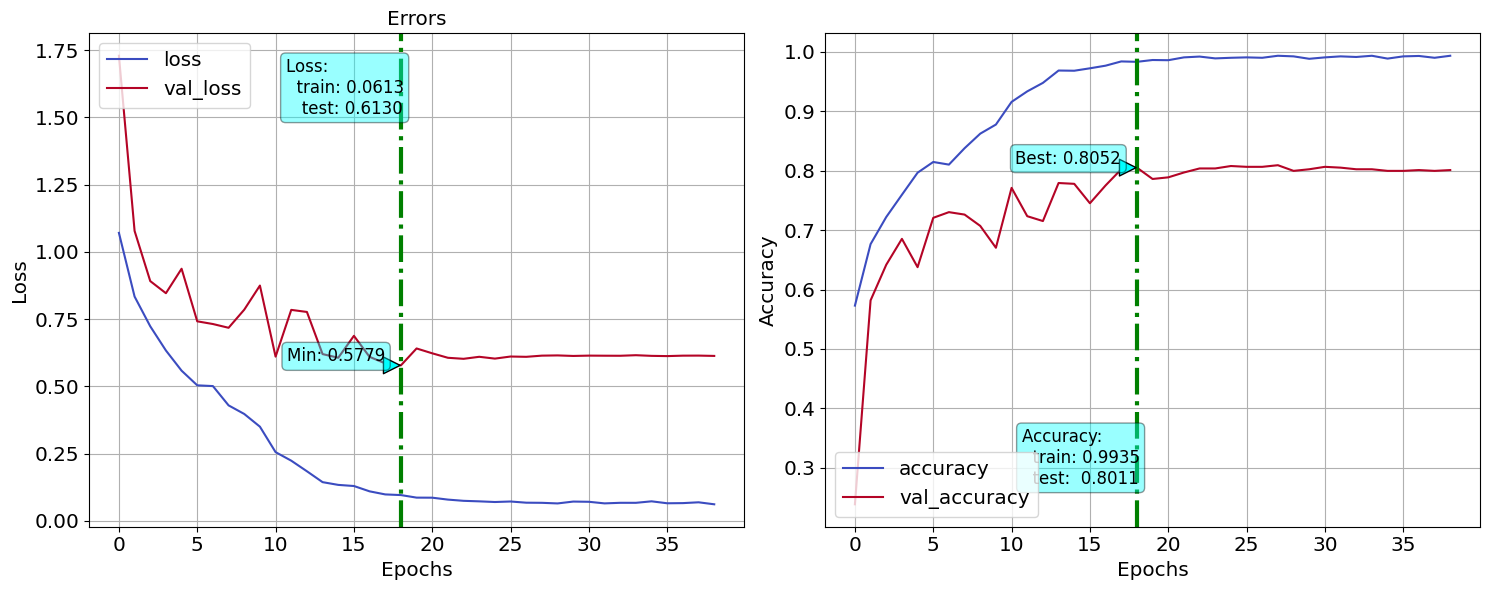

In [ ]:
plot_tf_hist(res_df)

## Testing preds

In [ ]:
test_loss,test_acc=model.evaluate(test_ds,verbose=2)

46/46 - 1s - loss: 0.5779 - accuracy: 0.8052 - 998ms/epoch - 22ms/step
